In [ ]:
import os
import pandas as pd
import seaborn as sns
import functions.token_functions as tf
import spacy
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import xgboost as xgb
import tensorflow as tf
from nltk.corpus import stopwords

In [2]:
nlp = spacy.load('en_core_web_sm')
sw = stopwords.words("english")

In [3]:
# Create an empty list to store the review dataframes
df_list = []

for root, dirs, files in os.walk('../data'):
    for filename in files:
        # Read the CSV file into a datadrame
        df = pd.read_csv(os.path.join(root, filename), index_col=0)

        # Append the dataframe to the list
        df_list.append(df)

# Combine the dataframes into a single dataframe
nlp_df = pd.concat(df_list, ignore_index=True)

In [4]:
# drop titles
nlp_df = nlp_df.drop(columns=['game_title','movie_title'])

# drop values
nlp_df = nlp_df.dropna()

# drop non english reviews
nlp_df['lang'] = nlp_df['review'].apply(tf.detect_language)

nlp_df = nlp_df.query('lang == "en"')

# convert review from float to int
nlp_df['rating'] = nlp_df['rating'].astype(int)

In [5]:
nlp_df['review_tokens'] = nlp_df['review'].apply(tf.clean_tokenize)
nlp_df['review_title_tokens'] = nlp_df['review_title'].apply(tf.clean_tokenize)

In [17]:
nlp_df.groupby(['rating'])['review'].count()

rating
1     6475
2     3899
3     6467
4    12774
5    91515
Name: review, dtype: int64

In [46]:
nlp_df['sentiment'] = 0
nlp_df.loc[nlp_df['rating']>3, 'sentiment'] = 2
nlp_df.loc[nlp_df['rating']==3, 'sentiment'] = 1
nlp_df.loc[nlp_df['rating']<3, 'sentiment'] = 0

<AxesSubplot:xlabel='sentiment', ylabel='count'>

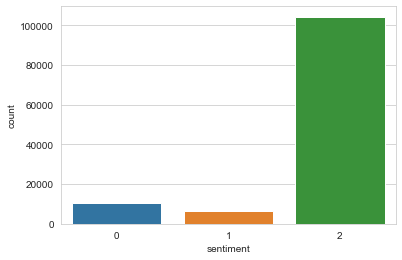

In [49]:
sns.countplot(x=nlp_df['sentiment'])

<AxesSubplot:xlabel='rating', ylabel='count'>

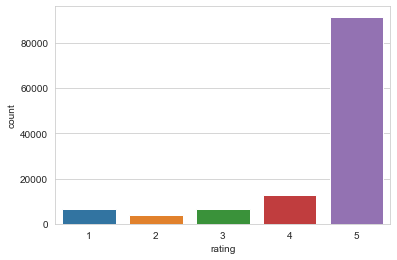

In [50]:
sns.countplot(x=nlp_df['rating'])

In [51]:
no_5 = nlp_df.query('rating != 5')
just_5 = nlp_df.query('rating == 5')

In [53]:
adjusted_5 = resample(just_5,
                      replace=False,
                      n_samples=15000,
                      random_state=10)

In [54]:
adj_nlp_df = pd.concat([adjusted_5, no_5])

<AxesSubplot:xlabel='sentiment', ylabel='count'>

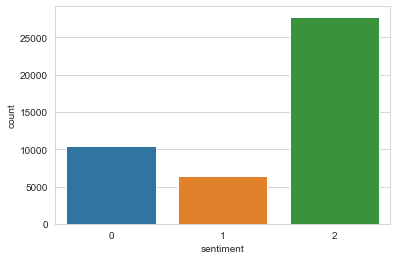

In [55]:
sns.countplot(x=adj_nlp_df['sentiment'])


<AxesSubplot:xlabel='rating', ylabel='count'>

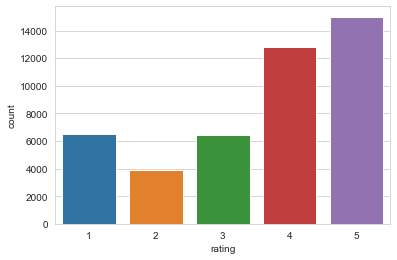

In [56]:
sns.countplot(x=adj_nlp_df['rating'])

## Split Data

In [141]:
X_train, X_test, y_train, y_test = train_test_split(adj_nlp_df['review'], adj_nlp_df['sentiment'], test_size=0.20, random_state=10, stratify=adj_nlp_df['sentiment'])

In [142]:
tf.sentiment_stats(X_train, X_test, y_train, y_test)

Size of Training Data  35692
Size of Test Data  8923
Distribution of classes in Training Data :
Positive Sentiment  14.49624565729015
Negative Sentiment  23.25170906645747
Distribution of classes in Testing Data :
Positive Sentiment  14.490642160708282
Negative Sentiment  23.254510814748404


## Vectorize Data

In [143]:
tfidf = TfidfVectorizer(min_df = 20, max_df=.2 ,ngram_range=(1,1),stop_words=sw)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)
X_train_tf.shape

(35692, 4552)

## Train Sentiment Model

In [152]:
svc_model = OneVsRestClassifier(LinearSVC(random_state=10, tol=1e-5))
svc_model.fit(X_train_tf, y_train)

xgb_model = xgb.XGBClassifier(random_state=10)
xgb_model.fit(X_train_tf, y_train)

rf_model = RandomForestClassifier(random_state=10)
rf_model.fit(X_train_tf, y_train)


RandomForestClassifier(random_state=10)

In [1]:
# Define the neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_tf.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

NameError: name 'tf' is not defined

In [149]:
y_pred = svc_model.predict(X_test_tf)

print ('Accuracy Score - ', accuracy_score(y_test, y_pred))
print ('Precision - ', precision_score(y_test, y_pred, average='macro'))
print ('Recall - ', recall_score(y_test, y_pred, average='macro'))
print ('F1 Score - ', f1_score(y_test, y_pred, average='macro'))

Accuracy Score -  0.7709290597332735
Precision -  0.6580190180509083
Recall -  0.6175632068000918
F1 Score -  0.6260345814892793


In [150]:
y_pred = xgb_model.predict(X_test_tf)

print ('Accuracy Score - ', accuracy_score(y_test, y_pred))
print ('Precision - ', precision_score(y_test, y_pred, average='macro'))
print ('Recall - ', recall_score(y_test, y_pred, average='macro'))
print ('F1 Score - ', f1_score(y_test, y_pred, average='macro'))

Accuracy Score -  0.7432477866188502
Precision -  0.6640354112185828
Recall -  0.5522335234110446
F1 Score -  0.5708030427978201


In [153]:
y_pred = rf_model.predict(X_test_tf)

print ('Accuracy Score - ', accuracy_score(y_test, y_pred))
print ('Precision - ', precision_score(y_test, y_pred, average='macro'))
print ('Recall - ', recall_score(y_test, y_pred, average='macro'))
print ('F1 Score - ', f1_score(y_test, y_pred, average='macro'))

Accuracy Score -  0.7463857447046958
Precision -  0.6688002964892039
Recall -  0.5400618715604822
F1 Score -  0.5359368600441997


## Sample Predictions

In [62]:
sample_reviews = nlp_df.sample(5)
sample_reviews_tf = tfidf.transform(sample_reviews['review'])
sentiment_predictions = svc_model.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['review','sentiment_prediction']]

Some sample reviews with their sentiment - 


,review,sentiment_prediction
41186,A simple framework for forming yourself into a...,2
67602,Love this book. Has fun facts and actual simpl...,2
44049,Easy to read. He does’t try to be smarter than...,2
21945,Bought for granddaughters,2
73478,"Still enjoying the book, but it may appeal to ...",2


In [65]:
text = ['This game is amazing!']
test = tfidf.transform(text)
test_pred = svc_model.predict(test)

test_pred

#test_review = pd.concat([text, test_pred], axis=1)
#print ('Some sample reviews with their sentiment - ')
#sample_reviews[['review','sentiment_prediction']]

array([2])

## Pickle Models

In [128]:
with open('../models/svc_model.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

with open('../models/tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)